In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
import numpy as np
import copy
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import wilcoxon
from scipy.optimize import curve_fit
from scipy.stats import fisher_exact
from scipy import stats
from math import floor

hfont = {'fontname':'Arial'}
plt.rcParams["font.family"] = "Arial"

#Code borrowed heavily from here: https://stackoverflow.com/questions/62375034/find-non-overlapping-area-between-two-kde-plots
plt.rcParams.update(
    {"text.usetex": False}
)


C:\Users\astar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [22]:
#BE SURE TO SAVE THIS VERSION FOR NOW

#+/- 5 stdevs, but extend out fully to cover pretty much all possibilities
strong_neg_bounds = [-1, -0.01709986320109439]
strong_pos_bounds = [0.01709986320109439, 1]

#+/- 2 stdevs, but replace with the bounds from below to capture the full possibilities
med_neg_bounds = [-0.01709986320109439, -0.006839945280437756]
med_pos_bounds = [0.006839945280437756, 0.01709986320109439]

#+/- 1 stdevs, but replace with the bounds from below to capture the full possibilities
#We could adjust this so that even if it is in these bounds, there is some probability of it being assigned to the exponential distribution
low_neg_bounds = [-0.006839945280437756, -0.0030779753761969904]
low_pos_bounds = [0.0030779753761969904, 0.006839945280437756]

exp_neg_bounds = [-0.0030779753761969904, 0]
exp_pos_bounds = [0, 0.0030779753761969904]

In [26]:
scs_0 = 0
scs_strong_neg = 0
scs_strong_pos = 0
scs_med_neg = 0
scs_med_pos = 0
scs_low_neg = 0
scs_low_pos = 0
scs_exp_neg = 0
scs_exp_pos = 0

pcs_0 = 0
pcs_strong_neg = 0
pcs_strong_pos = 0
pcs_med_neg = 0
pcs_med_pos = 0
pcs_low_neg = 0
pcs_low_pos = 0
pcs_exp_neg = 0
pcs_exp_pos = 0

df = pd.read_csv("661_TEST_NONCOD_Bene0.001_200kbElem.txt", sep = "\t")
for index, row in df.iterrows():
    sub_coeffs = np.array(row["SubCoeffs_Fixed"].split(",")).astype(float)
    
    #Count neutral substitutions
    scs_0 += len(np.where(sub_coeffs == 0)[0])
    
    #Count strong neg/pos substitutions
    scs_strong_neg += len(np.where(sub_coeffs < strong_neg_bounds[1])[0])
    scs_strong_pos += len(np.where(sub_coeffs > strong_pos_bounds[0])[0])
    
    #Count medium neg/pos substitutions
    scs_med_neg += len(np.where((sub_coeffs < med_neg_bounds[1]) & (sub_coeffs >= med_neg_bounds[0]))[0])
    scs_med_pos += len(np.where((sub_coeffs > med_pos_bounds[0]) & (sub_coeffs <= med_pos_bounds[1]))[0])
    
    #Count weak neg/pos substitutions
    scs_low_neg += len(np.where((sub_coeffs < low_neg_bounds[1]) & (sub_coeffs >= low_neg_bounds[0]))[0])
    scs_low_pos += len(np.where((sub_coeffs > low_pos_bounds[0]) & (sub_coeffs <= low_pos_bounds[1]))[0])
    
    #Count neg/pos substitutions drawn from the exponential distribution
    scs_exp_neg += len(np.where((sub_coeffs < exp_neg_bounds[1]) & (sub_coeffs >= exp_neg_bounds[0]))[0])
    scs_exp_pos += len(np.where((sub_coeffs > exp_pos_bounds[0]) & (sub_coeffs <= exp_pos_bounds[1]))[0])
    
    #Now do the same for the polymorphisms, requiring MAF > 0.1 and MAF < 0.9
    
    try:
        poly_coeffs = np.array(row["SubCoeffs_Poly"].split(",")).astype(float)
        mafs = np.array(row["AlleleFreqs"].split(",")).astype(float)
        poly_coeffs = poly_coeffs[np.where((mafs < 0.9) & (mafs > 0.1))]

        #Count neutral substitutions
        pcs_0 += len(np.where(poly_coeffs == 0)[0])

        #Count strong neg/pos substitutions
        pcs_strong_neg += len(np.where(poly_coeffs < strong_neg_bounds[1])[0])
        pcs_strong_pos += len(np.where(poly_coeffs > strong_pos_bounds[0])[0])

        #Count medium neg/pos substitutions
        pcs_med_neg += len(np.where((poly_coeffs < med_neg_bounds[1]) & (poly_coeffs >= med_neg_bounds[0]))[0])
        pcs_med_pos += len(np.where((poly_coeffs > med_pos_bounds[0]) & (poly_coeffs <= med_pos_bounds[1]))[0])

        #Count weak neg/pos substitutions
        pcs_low_neg += len(np.where((poly_coeffs < low_neg_bounds[1]) & (poly_coeffs >= low_neg_bounds[0]))[0])
        pcs_low_pos += len(np.where((poly_coeffs > low_pos_bounds[0]) & (poly_coeffs <= low_pos_bounds[1]))[0])

        #Count neg/pos substitutions drawn from the exponential distribution
        pcs_exp_neg += len(np.where((poly_coeffs < exp_neg_bounds[1]) & (poly_coeffs >= exp_neg_bounds[0]))[0])
        pcs_exp_pos += len(np.where((poly_coeffs > exp_pos_bounds[0]) & (poly_coeffs <= exp_pos_bounds[1]))[0])
    except:
        print(row["SubCoeffs_Poly"])
   
    


In [27]:
#Now lets make the distributions from which we will draw the PhyloP scores
df = pd.read_csv("G250.MskHum.PhyloP.bins.txt", sep = "\t", header = None)
df[0] = df[0]//100
df.columns = ['Counts', 'Bins']
df["Bin edge 1"] = [i.split(":")[0] for i in df["Bins"]]
#sns.barplot(data = df, y = 'Counts', x = "Bin edge 1")


In [28]:
#Create the multinomial distribution for the neutral sites
df1 = df[df["Bin edge 1"].astype(float) <= 1]
neut_multi_dist = df1["Counts"]/np.sum(df1["Counts"])

#Create the multinomial distribution for the exponential distributions
df2 = df[(df["Bin edge 1"].astype(float) > 1) & (df["Bin edge 1"].astype(float) <= 5)]
exp_multi_dist = df2["Counts"]/np.sum(df2["Counts"])

#Create the multinomial distribution for the low s
df3 = df[(df["Bin edge 1"].astype(float) > 5) & (df["Bin edge 1"].astype(float) <= 6)]
low_multi_dist = df3["Counts"]/np.sum(df3["Counts"])

#Create the multinomial distribution for the medium s
df4 = df[(df["Bin edge 1"].astype(float) > 6) & (df["Bin edge 1"].astype(float) <= 7.5)]
med_multi_dist = df4["Counts"]/np.sum(df4["Counts"])

#Create the multinomial distribution for the strong s
df5 = df[(df["Bin edge 1"].astype(float) > 7.5) & (df["Bin edge 1"].astype(float) <= 13)]
strong_multi_dist = df5["Counts"]/np.sum(df5["Counts"])



In [29]:
df1["Bin edge 1"] = df1["Bin edge 1"].astype(float)

#Neutral subtitution PhyloP distribution
p_0 = np.repeat(df1["Bin edge 1"], np.random.multinomial(scs_0, neut_multi_dist))

#Exponential substitution PhyloP distribution
p_e = np.repeat(df2["Bin edge 1"], np.random.multinomial(scs_exp_pos + scs_exp_neg, exp_multi_dist))

#Low substitution PhyloP distribution
p_l = np.repeat(df3["Bin edge 1"], np.random.multinomial(scs_low_pos + scs_low_neg, low_multi_dist))

#Medium substitution PhyloP distribution
p_m = np.repeat(df4["Bin edge 1"], np.random.multinomial(scs_med_pos + scs_med_neg, med_multi_dist))

#Strong substitution PhyloP distribution
p_s = np.repeat(df5["Bin edge 1"], np.random.multinomial(scs_strong_pos + scs_strong_neg, strong_multi_dist))

#Full subsitution distribution
sub = np.array(list(p_0) + list(p_e) + list(p_l) + list(p_m) + list(p_s))


#Neutral polymorphism PhyloP distribution
pp_0 = np.repeat(df1["Bin edge 1"], np.random.multinomial(pcs_0, neut_multi_dist))

#Exponential polymorphism PhyloP distribution
pp_e = np.repeat(df2["Bin edge 1"], np.random.multinomial(pcs_exp_pos + pcs_exp_neg, exp_multi_dist))

#Low polymorphism PhyloP distribution
pp_l = np.repeat(df3["Bin edge 1"], np.random.multinomial(pcs_low_pos + pcs_low_neg, low_multi_dist))

#Medium polymorphism PhyloP distribution
pp_m = np.repeat(df4["Bin edge 1"], np.random.multinomial(pcs_med_pos + pcs_med_neg, med_multi_dist))

#Strong polymorphism PhyloP distribution
pp_s = np.repeat(df5["Bin edge 1"], np.random.multinomial(pcs_strong_pos + pcs_strong_neg, strong_multi_dist))

#Full polymorphism distribution
poly = np.array(list(pp_0) + list(pp_e) + list(pp_l) + list(pp_m) + list(pp_s))

C:\Users\astar\AppData\Local\Temp\ipykernel_13444\3328196086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["Bin edge 1"] = df1["Bin edge 1"].astype(float)


In [30]:
dff = pd.DataFrame(sub)
dff.columns = ["PhyloP"]
dff["FixedOrPoly"] = np.repeat("Fixed", dff.shape[0])

dff2 = pd.DataFrame(poly)
dff2.columns = ["PhyloP"]
dff2["FixedOrPoly"] = np.repeat("Polymorphic", dff2.shape[0])
dff = pd.concat([dff, dff2])
dff["PhyloP"] = dff["PhyloP"].astype(float)

In [33]:
#Function to prepare to compute alpha
def prepare_alpha(fixed, poly, stat = "PhyloP447", title = ""):
    x = np.repeat("Fixed", len(list(fixed.index)))
    y = np.repeat("Polymorphic", len(list(poly.index)))
    z = np.repeat(".", len(list(fixed.index)))
    poly["FixedOrPoly"] = y
    fixed["FixedOrPoly"] = x
    fixed["MAFMaxAcrossAncestry"] = z
    if "UnfoldedMAF" in poly.columns:
        fixed["UnfoldedMAF"] = z
        v2 = fixed[["FixedOrPoly", stat, "MAFMaxAcrossAncestry", "UnfoldedMAF"]].copy()
        vv2 = poly[["FixedOrPoly", stat, "MAFMaxAcrossAncestry", "UnfoldedMAF"]].copy()
    else:
        v2 = fixed[["FixedOrPoly", stat, "MAFMaxAcrossAncestry"]].copy()
        vv2 = poly[["FixedOrPoly", stat, "MAFMaxAcrossAncestry"]].copy()
    x2 = v2[stat]
    yvals2 = vv2[stat]
    vvv = pd.concat([v2, vv2])
    vvv["PhyloP"] = vvv[stat].astype(float)
    return vvv

#Code to compute alpha
def compute_alpha_new(vvv, dn_cut = 0.05, cutoff = 2, plot = False, sub = False, stat = "PhyloP", window = [-5, 12], title = ""):
    x0 = vvv[vvv["FixedOrPoly"].isin(["Fixed"])][stat].astype(float)
    x1 = vvv[vvv["FixedOrPoly"].isin(["Polymorphic"])][stat].astype(float)
        
    dn1 = vvv[(vvv[stat] > cutoff) & (vvv["FixedOrPoly"] == "Fixed")].shape[0]
    pn1 = vvv[(vvv[stat] > cutoff) & (vvv["FixedOrPoly"] == "Polymorphic")].shape[0]
    ds1 = vvv[(vvv[stat] <= cutoff) & (vvv["FixedOrPoly"] == "Fixed")].shape[0]
    ps1 = vvv[(vvv[stat] <= cutoff) & (vvv["FixedOrPoly"] == "Polymorphic")].shape[0]
    alpha1 = 1 - (ds1/dn1)*(pn1/ps1)
    
    dn2 = vvv[(vvv[stat] >= cutoff) & (vvv["FixedOrPoly"] == "Fixed")].shape[0]
    pn2 = vvv[(vvv[stat] >= cutoff) & (vvv["FixedOrPoly"] == "Polymorphic")].shape[0]
    ds2 = vvv[(vvv[stat] < cutoff) & (vvv["FixedOrPoly"] == "Fixed")].shape[0]
    ps2 = vvv[(vvv[stat] < cutoff) & (vvv["FixedOrPoly"] == "Polymorphic")].shape[0]
    alpha2 = 1 - (ds2/dn2)*(pn2/ps2)
    
    alpha = (alpha1 + alpha2)/2
    #Plot the kdes if desired
    if plot:
        #Smooth the distributions
        kde0 = gaussian_kde(x0, bw_method=0.3)
        kde1 = gaussian_kde(x1, bw_method=0.3)

        #Get the range to compute on
        xmin = min(x0.min(), x1.min())
        xmax = max(x0.max(), x1.max())
        dx = 0.2 * (xmax - xmin) # add a 20% margin, as the kde is wider than the data
        xmin -= dx
        xmax += dx

        x = np.linspace(xmin, xmax, 500)
        kde0_x = kde0(x)
        kde1_x = kde1(x)
    
        fig, ax = plt.subplots(figsize=(10,6))
        ax.plot(x, kde0_x, color='b', label='Fixed')
        ax.fill_between(x, kde0_x, 0, color='b', alpha=0.2)
        ax.plot(x, kde1_x, color='orange', label='Polymorphic')
        ax.fill_between(x, kde1_x, 0, color='orange', alpha=0.2)
        handles, labels = plt.gca().get_legend_handles_labels()
        ax.legend(handles, labels, title='', frameon=False, fontsize = 16)
        ax.set_xlabel("PhyloP", **hfont, fontsize = 18)
        ax.set_ylabel("Density", **hfont, fontsize = 18)
        ax.set_xlim(window[0], window[1])
        plt.tight_layout()
        if title:
            ax.set_title(title, fontsize = 22)
        #plt.show()
    tag = "dc > 0.1, likely stable"
    plt.ylim(0, 0.08)
    #Returns alpha, the starting point for computing, all the crossing points, whether the estimate is likely to be stable, the table, and the figure if needed
    if plot:
        return alpha, cutoff, [[dn1, ds1], [pn1, ps1]], [[dn2, ds2], [pn2, ps2]], fig
    else:
        return alpha, cutoff, [[dn1, ds1], [pn1, ps1]], [[dn2, ds2], [pn2, ps2]]


(-0.009672835657380197,
 2.294930000000001,
 [[55958, 1173992], [18791, 391974]],
 [[60595, 1169355], [20498, 390267]],
 <Figure size 1000x600 with 1 Axes>)

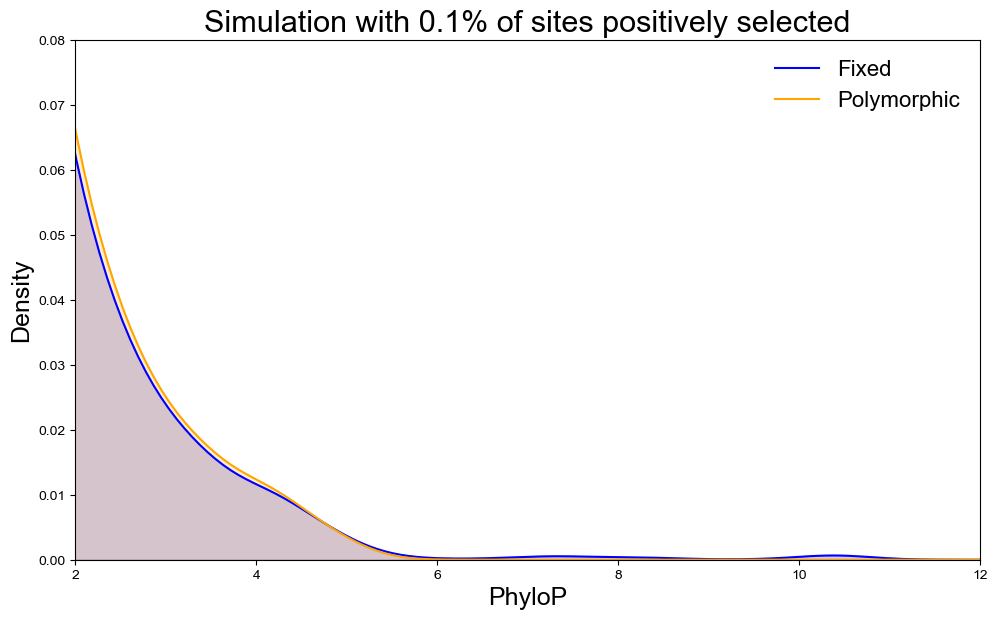

In [35]:
compute_alpha_new(dff, dn_cut = 0, title = "Simulation with 0.1% of sites positively selected", cutoff = cutoff, plot = True, window = [2, 12])

(-0.07507022737661906,
 2.294930000000001,
 [[52667, 1165403], [20291, 417642]],
 [[52667, 1165403], [20291, 417642]],
 <Figure size 1000x600 with 1 Axes>)

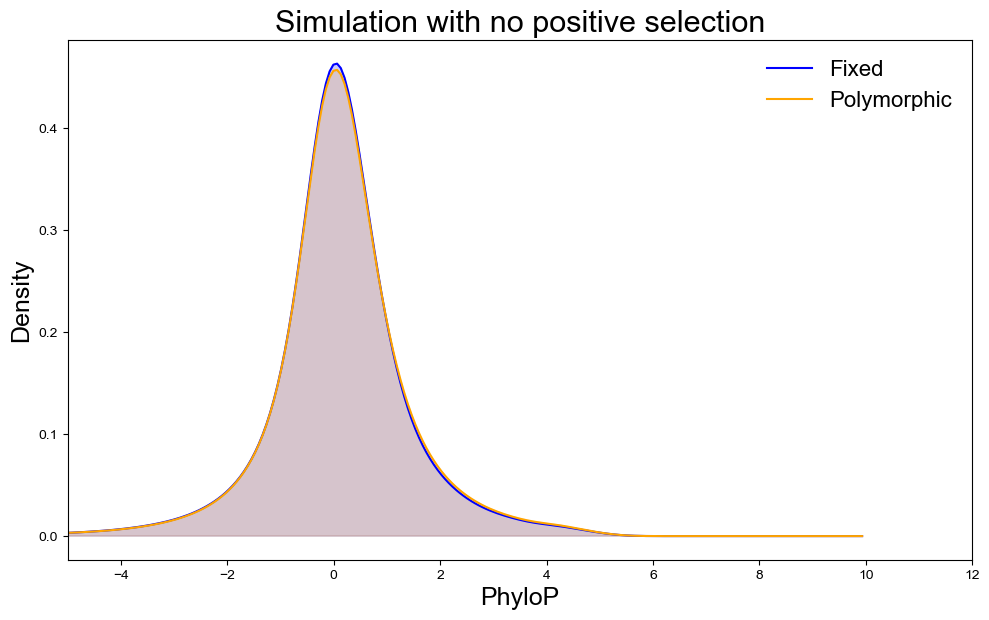

In [10]:
from math import floor

cuttt = 0.95
z = list(dff[dff["FixedOrPoly"] == "Polymorphic"].sort_values("PhyloP")["PhyloP"])

cutoff = z[floor(len(z)*cuttt)]

compute_alpha_new(dff, plot = True, dn_cut = 0, title = "Simulation with no positive selection", cutoff = cutoff)

In [16]:
compute_alpha_new(dff, plot = True, dn_cut = 0, title = "Simulation with no positive selection", cutoff = cutoff, window = [1, 8])

KeyboardInterrupt: 

(-0.07619111009005353,
 2.294930000000001,
 [[52667, 1165403], [20291, 417642]],
 [[57130, 1160940], [22048, 415885]],
 <Figure size 1000x600 with 1 Axes>)

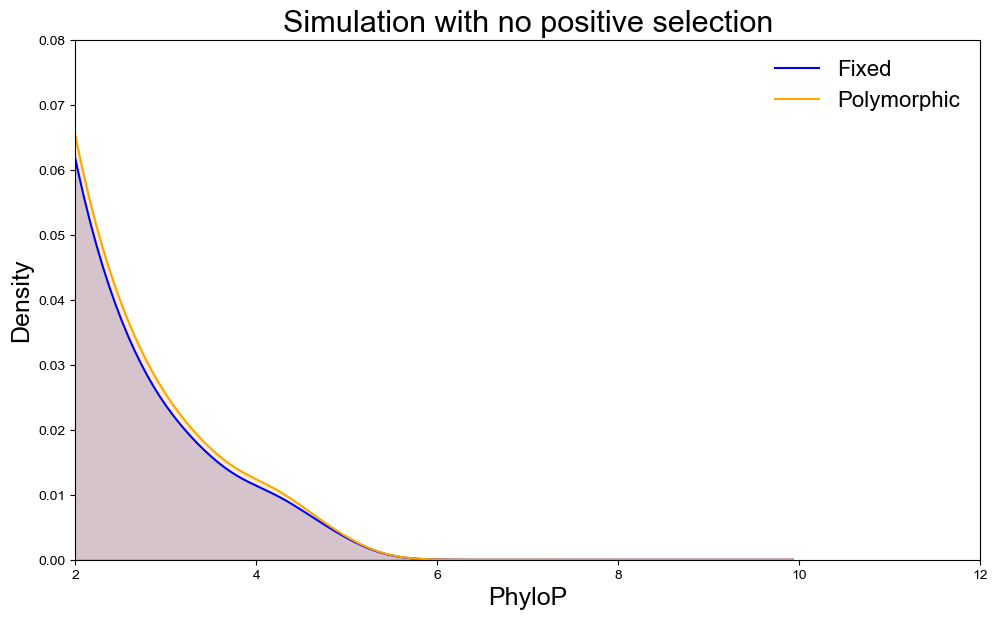

In [20]:
compute_alpha_new(dff, plot = True, dn_cut = 0, title = "Simulation with no positive selection", cutoff = cutoff, window = [2, 12])

-0.07522907326953754


(-0.0677118951658997,
 -0.006559786239144216,
 [0.7631876619906492, 9.930179999999996],
 'dc < 0.1, may be unstable',
 [[52967, 1165103], [20273, 417660]],
 <Figure size 1000x600 with 1 Axes>)

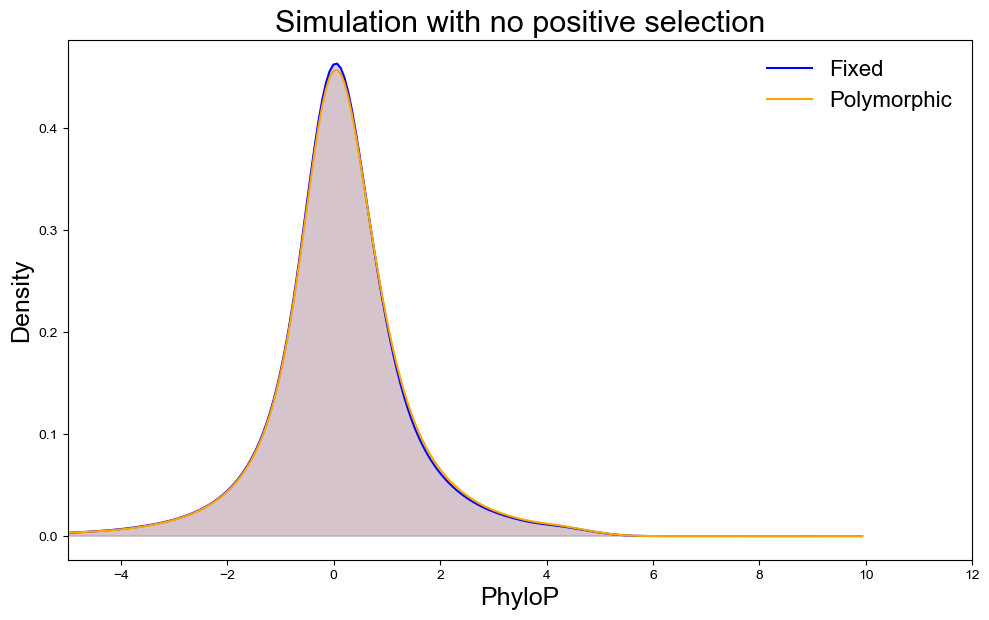

In [31]:
from math import floor

cuttt = 0.95
z = list(dff[dff["FixedOrPoly"] == "Polymorphic"].sort_values("PhyloP")["PhyloP"])

cutoff = z[floor(len(z)*cuttt)]

compute_alpha_new(dff, plot = True, dn_cut = 0, title = "Simulation with no positive selection", cutoff = cutoff)

0.8779406179083811


(0.04889817505460736,
 0.8133344742818913,
 [0.8133344742818913,
  2.435944957915826,
  4.656359303941212,
  16.527035999999995],
 'dc > 0.1, likely stable',
 [[289095, 1033613], [53707, 201893]],
 <Figure size 1000x600 with 1 Axes>)

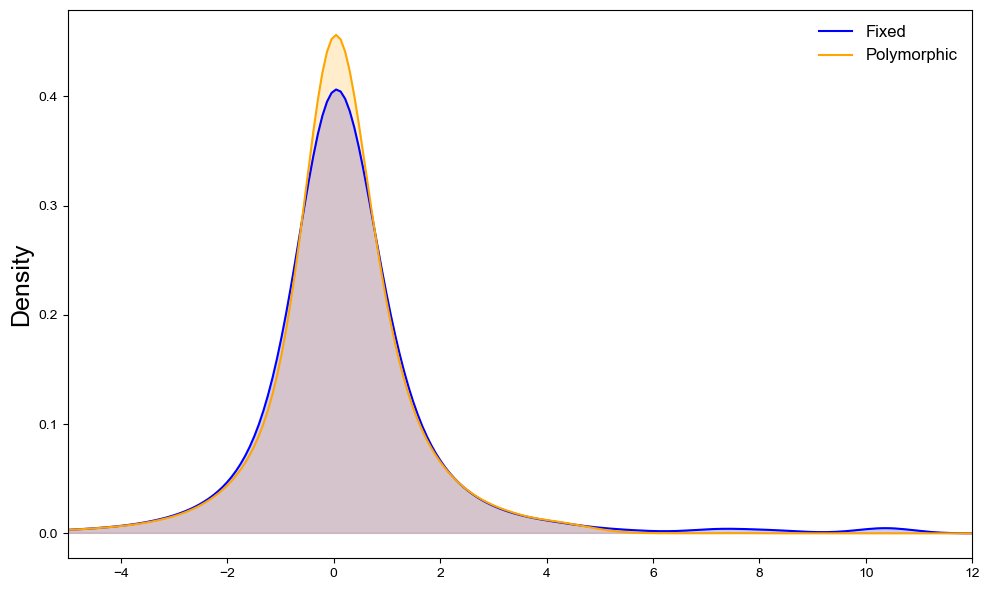

In [20]:
compute_alpha_new(dff, plot = True, dn_cut = 0)

0.8829588899428541


(0.0522401686838595,
 0.8133344742818913,
 [0.8133344742818913,
  2.521345509686032,
  4.570958752171002,
  16.527035999999995],
 'dc > 0.1, likely stable',
 [[289240, 1033468], [53585, 202015]],
 <Figure size 1000x600 with 1 Axes>)

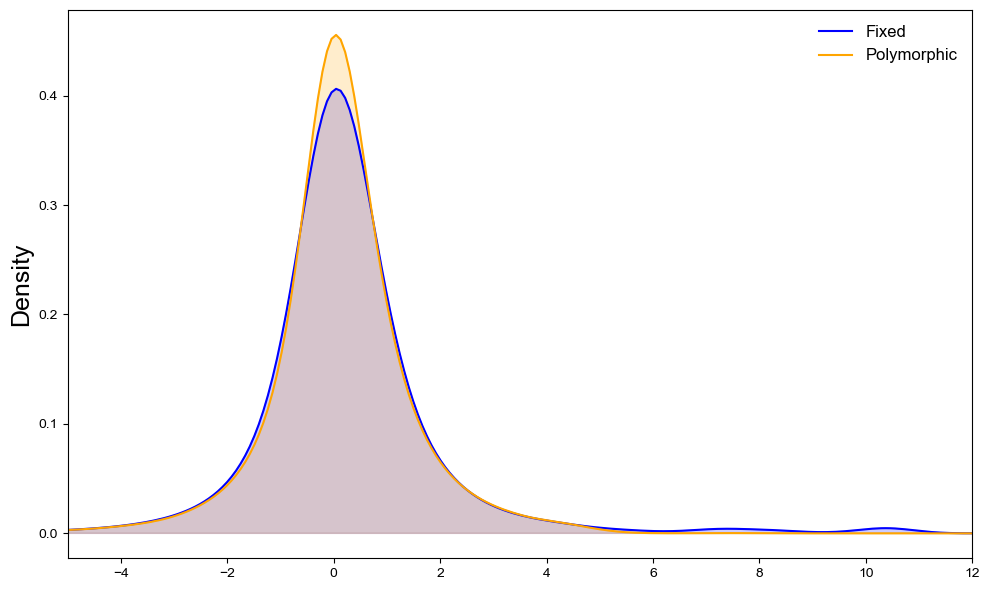

In [10]:
compute_alpha_new(dff, plot = True, dn_cut = 0)

0.9080453296521271


(0.14174418581847714,
 0.8133344742818913,
 [0.8133344742818913,
  3.8877543380093478,
  4.229356545090173,
  16.527035999999995],
 'dc > 0.1, likely stable',
 [[192383, 1046134], [27713, 175585]],
 <Figure size 1000x600 with 1 Axes>)

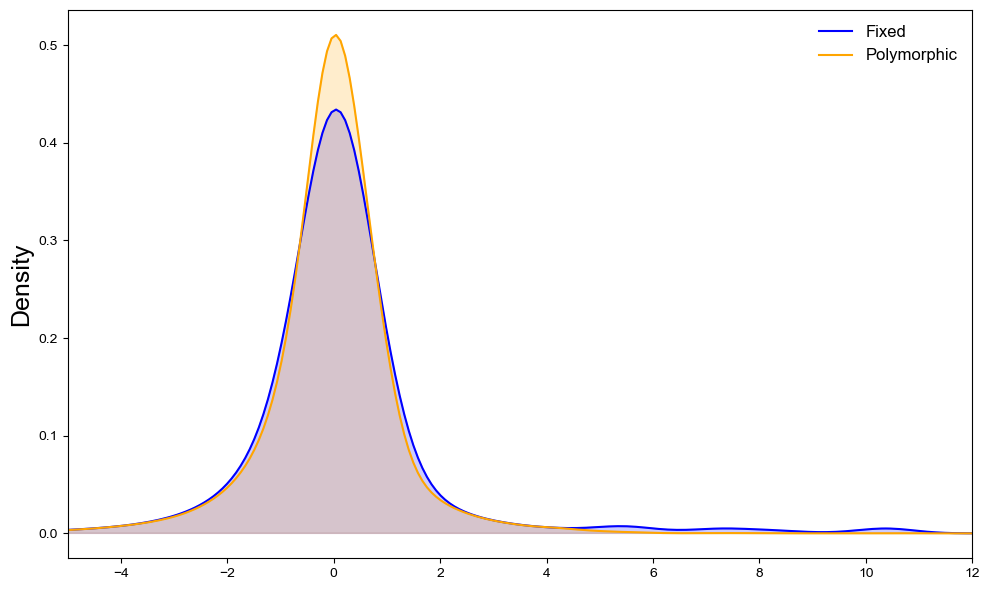

In [9]:
compute_alpha_new(dff, plot = True, dn_cut = 0)

0.9149889929578974


(-0.0089055981366295,
 0.8133344742818913,
 [0.8133344742818913,
  1.838141095524378,
  4.827160407481625,
  16.527035999999995],
 'dc > 0.1, likely stable',
 [[186727, 1037309], [34217, 188405]],
 <Figure size 1000x600 with 1 Axes>)

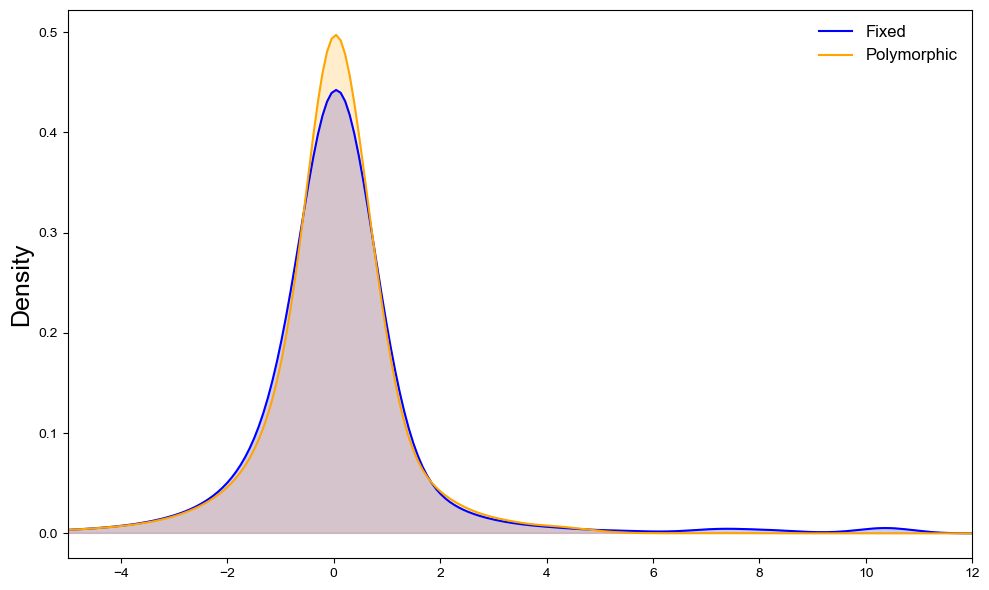

In [10]:
compute_alpha_new(dff, plot = True, dn_cut = 0)

0.9341526197338974


(0.39306989798848957,
 0.8987350260520977,
 [0.8987350260520977, 16.527035999999995],
 'dc > 0.1, likely stable',
 [[127442, 1048030], [18656, 252779]],
 <Figure size 1000x600 with 1 Axes>)

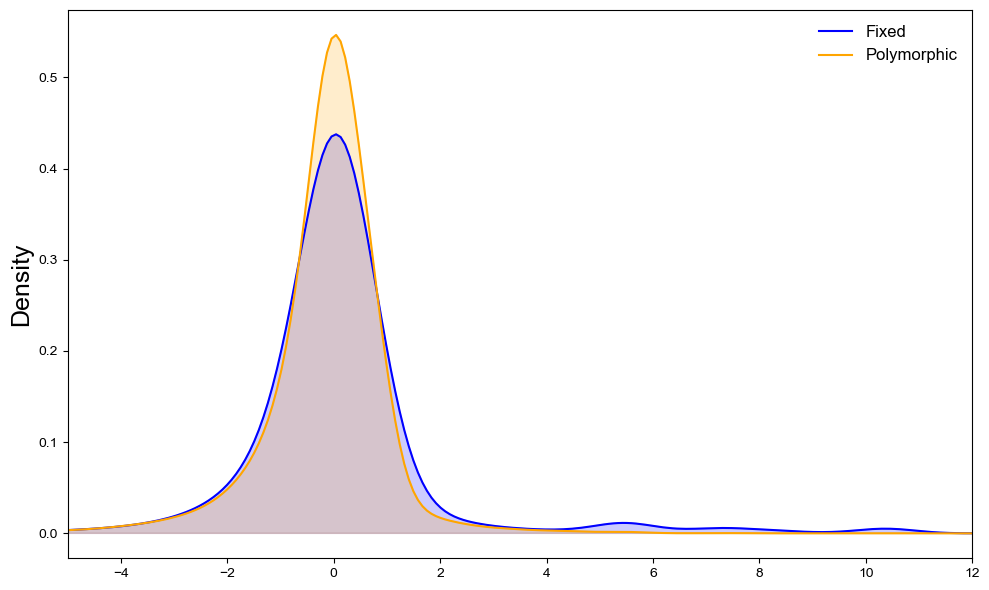

In [10]:
compute_alpha_new(dff, plot = True, dn_cut = 0)

0.9319949371568714


(0.31938603861058046,
 0.8133344742818913,
 [0.8133344742818913, 16.527035999999995],
 'dc > 0.1, likely stable',
 [[157418, 1018054], [25846, 245589]],
 <Figure size 1000x600 with 1 Axes>)

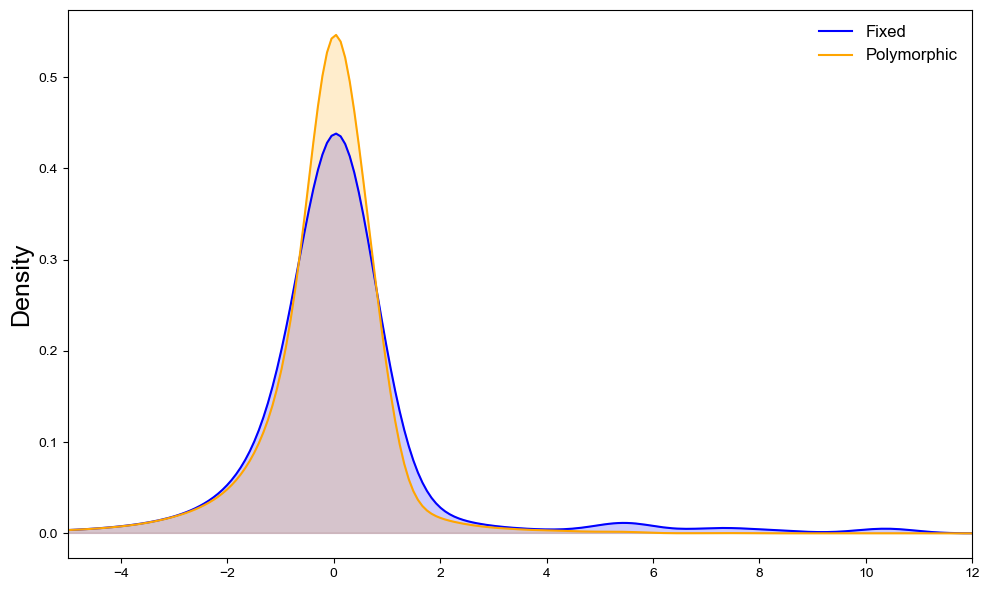

In [155]:
compute_alpha_new(dff, plot = True, dn_cut = 0)